### In this new : 
I am using the dataset with the 1:1's !

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from icecream import ic
import statsmodels.api as sm 
from statsmodels.regression import linear_model

In [175]:
data = pd.read_csv('../data/df-time-agg.csv')
data = data[data["person"]!="ingeborgR"]
data = data[(data["person"] != "adamF") | (data["coin"] != "0.05EUR") | (data["agg"] != 84)]


data_expanded = data.copy()
data_expanded['r'] = data["heads_heads"]+(data['N_start_tails_up']-data["tails_heads"])
data_expanded['m'] = data['N_start_tails_up']+data['N_start_heads_up']
data_expanded['rom'] = data_expanded['r'] / data_expanded['m']

print(len(data_expanded))

3409


In [211]:
WLS_model_0 = linear_model.WLS.from_formula(formula="(rom) ~ 1", data=data_expanded)
WLS_model_1 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)", data=data_expanded)
WLS_model_2 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+agg", data=data_expanded) # Best AIC 
WLS_model_3 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+agg+C(coin)", data=data_expanded) 
WLS_model_4 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+agg+C(coin)+C(person):C(coin)", data=data_expanded) # Best LRT
result_WLS_0 = WLS_model_0.fit()
result_WLS_1 = WLS_model_1.fit()
result_WLS_2 = WLS_model_2.fit()
result_WLS_3 = WLS_model_3.fit()
result_WLS_4 = WLS_model_4.fit()
print(f"\nAIC for the WLS_0: {result_WLS_0.aic:.2f}")
print(f"\nAIC for the WLS_1: {result_WLS_1.aic:.2f}")
print(f"\nAIC for the WLS_2: {result_WLS_2.aic:.2f}")
print(f"\nAIC for the WLS_3: {result_WLS_3.aic:.2f}")
print(f"\nAIC for the WLS_4: {result_WLS_4.aic:.2f}")
# lower AIC is better !
# We select model 2 with persons only !


AIC for the WLS_0: -10291.97

AIC for the WLS_1: -10435.99

AIC for the WLS_2: -10448.89

AIC for the WLS_3: -10419.55

AIC for the WLS_4: -10324.44


In [212]:
# LRT 

print(result_WLS_1.compare_lr_test(result_WLS_0, large_sample=False)) # 1 is better

print(result_WLS_2.compare_lr_test(result_WLS_1, large_sample=False)) # 2 is better

print(result_WLS_3.compare_lr_test(result_WLS_2, large_sample=False)) # 2 is better

(np.float64(236.01059848397017), np.float64(2.347538224064649e-27), np.float64(46.0))
(np.float64(14.907664672740793), np.float64(0.00011290333357902156), np.float64(1.0))
(np.float64(54.65684020891058), np.float64(0.09116305354242454), np.float64(42.0))


### ANOVA of selected model

In [215]:
table = sm.stats.anova_lm(result_WLS_3, typ=2) 
print(table)

             sum_sq      df         F        PR(>F)
C(person)  0.526187    46.0  4.261689  1.059450e-19
coin       0.143983    42.0  1.277208  1.093366e-01
agg        0.019116     1.0  7.121973  7.651535e-03
Residual   8.908563  3319.0       NaN           NaN


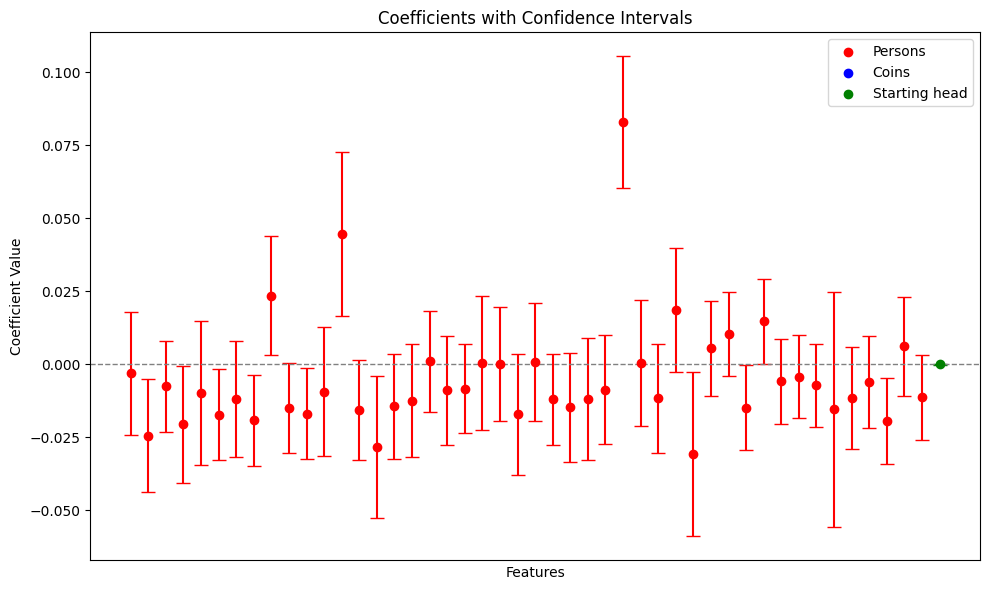

In [216]:
import re
# the introductory model 
result_WLS = result_WLS_2

coefficients = result_WLS.params
conf_int = result_WLS.conf_int()

# remove the constant coefficient : 
coefficients = result_WLS.params[1:]  # Exclude the first coefficient
conf_int = result_WLS.conf_int()[1:] 
conf_int_inf= list(conf_int[0])
conf_int_sup= list(conf_int[1])
feature_names = result_WLS.model.exog_names[1:]

# Determine colors based on the feature names
colors = [
    'red' if 'person' in feature else 'blue' if 'coin' in feature else "green"
    for feature in feature_names
]

# Create the plot
plt.figure(figsize=(10, 6))

# Clean the feature names
for i, (feature, coef, color) in enumerate(zip(feature_names, coefficients, colors)):
    plt.errorbar(
        x=i,
        y=coef,
        yerr=[[coef - conf_int_inf[i]], [conf_int_sup[i] - coef]],
        fmt='o',
        ecolor=color,  # Use the determined color for error bars
        color=color,   # Use the determined color for points
        capsize=5
    )

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Create a legend
plt.scatter([], [], color='red', label='Persons')   # Red legend entry
plt.scatter([], [], color='blue', label='Coins')    # Blue legend entry
plt.scatter([], [], color='green', label='Starting head')  # Green legend entry
plt.legend(loc='upper right')

# Add labels and title
plt.xlabel('Features')
plt.xticks([])
plt.ylabel('Coefficient Value')
plt.title('Coefficients with Confidence Intervals')
plt.tight_layout()
plt.show()

# selected model is 1+C(person)+agg

<Figure size 800x600 with 0 Axes>

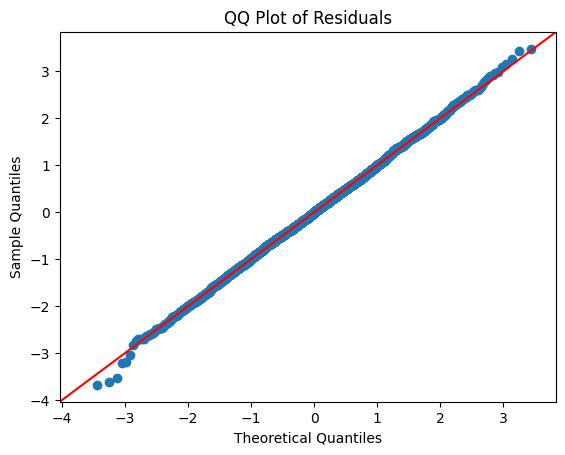

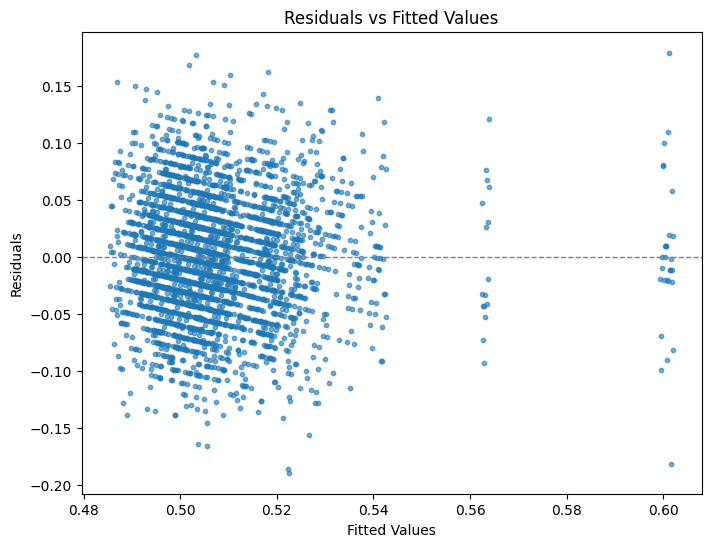

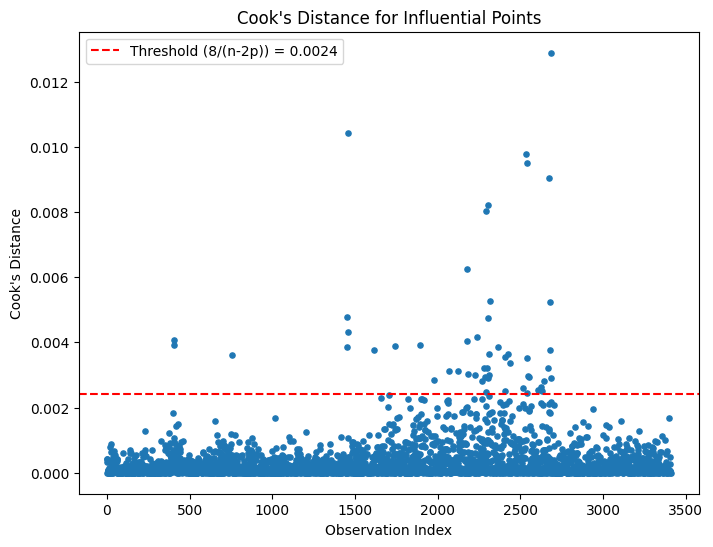

In [223]:
from statsmodels.stats.outliers_influence import OLSInfluence

WLS_model_complete = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+agg", data=data_expanded) # Best LRT
result_WLS_complete = WLS_model_complete.fit()

# Extract residuals and fitted values
residuals_complete = result_WLS_complete.resid # actual values minus the predicted value
fitted_values_complete = result_WLS_complete.fittedvalues # ok predicted values 
standardized_residuals_complete = residuals_complete / np.std(residuals_complete) # standardized residuals
standardized_residuals_complete = result_WLS_complete.resid_pearson

# QQ Plot (Normality of residuals)
plt.figure(figsize=(8, 6))
sm.qqplot(residuals_complete, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

# Residuals vs Fitted Values
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values_complete, residuals_complete, alpha=0.6,s=10)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# --------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------------

influence = OLSInfluence(result_WLS_complete)
p_complete = result_WLS_complete.df_model
n_complete = len(data_expanded)
cooks,y = influence.cooks_distance
threshold_complete = 8/(n_complete-2*p_complete)
#threshold_complete = 4/(n_complete)

# Plot Cook's Distance
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(cooks)), cooks,s=14)  
plt.title("Cook's Distance for Influential Points")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.axhline(y=threshold_complete, color='red', linestyle='--', label=f"Threshold (8/(n-2p)) = {threshold_complete:.4f}")
plt.legend()
plt.show()


In [220]:
# extract the only extreme cook :
influential_points = cooks > threshold_complete # Get the indices of the points with Cook's distance exceeding the threshold
influential_data = data_expanded[influential_points]

influential_data = influential_data[['person', 'coin', 'agg']]

# Print the results
print(f"Points with excessive Cook's distance (greater than {threshold_complete:.4f}):")
print(influential_data)


Points with excessive Cook's distance (greater than 0.0024):
                 person     coin  agg
488             madlenH  0.50EUR   29
490             madlenH  0.50EUR   31
842               jillR  0.20EUR   58
1538              irmaT     1EUR    1
1540              irmaT     1EUR    3
1541              irmaT     1EUR    4
1544              irmaT     1EUR    7
1699           JasonNak  0.20EUR    5
1829  KatharinaKarnbach     1GBP   13
1977        RietvanBork  0.05EUR   10
2065           AaronLob     2EUR   12
2153       AdrianKarami     2EUR   26
2211           ArneJohn     5SEK    6
2262            BohanFu  0.20EUR   18
2264            BohanFu  0.02EUR   20
2270                 EJ     2EUR    4
2313    FranziskaAssion     1EUR    6
2325    FranziskaAssion     1DEM   18
2354    HannahArmstrong     2CAD    9
2365    HannahArmstrong     1CAD   20
2374    HannahArmstrong     1CAD   29
2377            JanYang  0.50EUR    2
2380            JanYang  0.50EUR    5
2382            JanYang  0.

In [221]:
X_complete = WLS_model_complete.exog  # Design matrix
W_complete = np.diag(WLS_model_complete.weights)  # Diagonal weight matrix
n_complete = X_complete.shape[0]  
p_complete = X_complete.shape[1] 
print(p_complete)
print(np.linalg.matrix_rank(X_complete))

48
48


<Figure size 800x600 with 0 Axes>

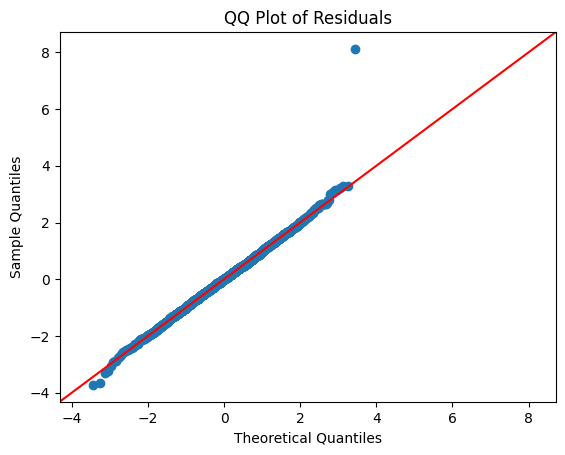

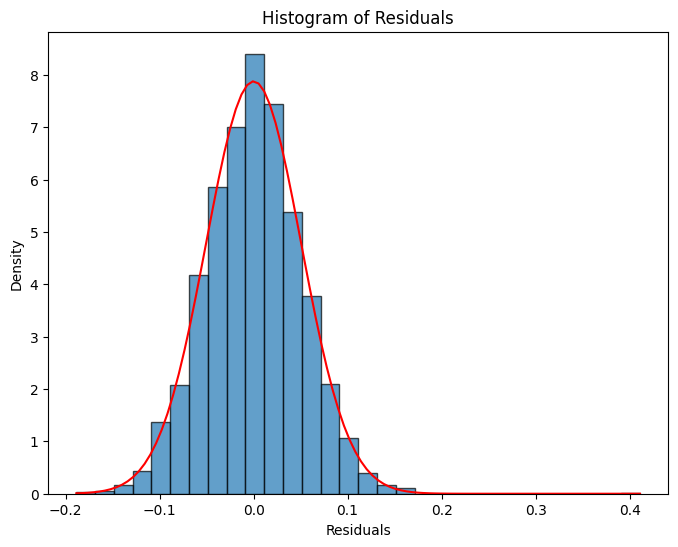

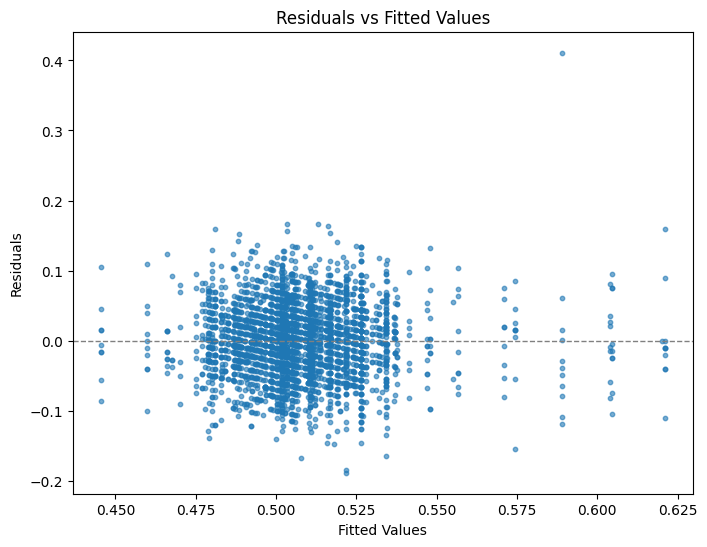

LinAlgError: Singular matrix

In [128]:
import scipy.stats as stats

# Extract residuals and fitted values
residuals_complete = result_WLS_complete.resid # actual values minus the predicted value
fitted_values_complete = result_WLS_complete.fittedvalues # ok predicted values 
standardized_residuals_complete = residuals_complete / np.std(residuals_complete) # standardized residuals
 

# QQ Plot (Normality of residuals)
plt.figure(figsize=(8, 6))
sm.qqplot(residuals_complete, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

# Histogram of Residuals (Check for normality)
plt.figure(figsize=(8, 6))
plt.hist(residuals_complete, bins=30, edgecolor='black', alpha=0.7, density=True)
# Overlay normal distribution
x = np.linspace(residuals_complete.min(), residuals_complete.max(), 100)
plt.plot(x, stats.norm.pdf(x, loc=np.mean(residuals_complete), scale=np.std(residuals_complete)), color='red')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Residuals vs Fitted Values
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values_complete, residuals_complete, alpha=0.6,s=10)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# ----------------------------------------------------------------------------------------------------
# COOK'S MEASURE : 
# ----------------------------------------------------------------------------------------------------
# Extract model data
X_complete = WLS_model_complete.exog  # Design matrix
W_complete = np.diag(WLS_model_complete.weights)  # Diagonal weight matrix
n_complete = X_complete.shape[0]  
p_complete = X_complete.shape[1] 

# matrix H
H_complete = W_complete @ X_complete @ np.linalg.inv(X_complete.T @ W_complete @ X_complete) @ X_complete.T @ W_complete
leverage_complete = np.diag(H_complete)  # diagonal of H, the hjj's in the slides

# Cook distance
standardized_residuals_complete = residuals_complete / np.std(residuals_complete)
cooks_d_complete= (standardized_residuals_complete**2 * leverage_complete) / (p * (1 - leverage_complete))
# check :::: cooks_d = (standardized_residuals**2 * leverage) / (p * (1 - leverage)**2)

# Threshold for Cook's Distance
threshold_complete = 8 / (n_complete - 2 * p_complete)

# Plot Cook's Distance
plt.figure(figsize=(8, 6))
plt.stem(np.arange(len(cooks_d_complete)), cooks_d_complete)  
plt.title("Cook's Distance for Influential Points")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.axhline(y=threshold_complete, color='red', linestyle='--', label=f"Threshold (8/(n-2p)) = {threshold:.4f}")
plt.legend()
plt.tight_layout()
plt.show()

influential_points_complete = np.where(cooks_d_complete > threshold_complete)[0] # extreme points 
print(f"Influential points (index): {influential_points_complete}")

# I would like to see which are the ones having the biggest cook's distance: 